In the following notebook, I will be modeling consumer behavior in relation to energy demand. I am hoping to find specific patterns of energy use on a daily basis.

Model different consumer behaviors to create consumer profiles based on electricity demand using a clustering algorithm. I will extract times during the day they use power the most & least and try to draw additional insights about their behavior. Better understanding our consumers will allow us to devise rebate programs to incentivize consumers to limit power usage during specific times of the day/year when we forecast demand to be very high(helping energy production companies lower cost).

## Prepare Notebook

**Read in libraries**

In [228]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

**Set Notebook Preferences**

In [229]:
#Set Pandas preferenes
pd.options.display.max_columns = 100

#Set style for matplotlib
plt.style.use('seaborn')

**Read in data**

In [230]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\02_Cleaned_Data'

#Read in data
df = pd.read_csv(path + '/2020_0620_Weather_Energy.csv')

**Preview data**

In [231]:
display(df.head())

,date_time,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,price_actual,price_day_ahead,temp,total_load_actual,total_load_forecast
0,2015-01-01 00:00:00,17.0,6436.0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,65.41,50.10,30.814633,25385.0,26118.0
1,2015-01-01 01:00:00,16.0,5856.0,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,64.92,48.10,30.852860,24382.0,24934.0
2,2015-01-01 02:00:00,8.0,5454.0,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,64.48,47.33,30.108448,22734.0,23515.0
3,2015-01-01 03:00:00,2.0,5151.0,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,59.32,42.27,30.091044,21286.0,22642.0
4,2015-01-01 04:00:00,9.0,4861.0,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,56.04,38.41,30.192620,20264.0,21785.0


# Clustering electricity usage profiles with K-means

**Prepare data**

In [232]:
#Filter columns only pertaining to demand and time
demand = df.filter(regex='load_actual|date')

#Split date_time into hour and data
demand[['date','hour']] = demand['date_time'].str.split(' ', expand=True)

#Drop original date_time data
demand.drop('date_time', axis =1, inplace = True)

#Create pivot table such that each row is a day and cols are each hour of the day
demand = demand.pivot_table(values = 'total_load_actual', columns='hour', index = 'date')

#Check
display(demand.head())

C:\Users\kishe\Miniconda3\envs\Spain_Energy_TimeSeries\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\kishe\Miniconda3\envs\Spain_Energy_TimeSeries\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,27927.0,29072.0,29071.0,29439.0,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,26454.0,26959.0,26716.0,26802.0,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0
2015-01-04,25254.0,23620.0,22606.0,22191.0,21929.0,22195.0,24035.0,26807.0,28316.0,29871.0,30585.0,30772.0,30685.0,30429.0,28741.0,28249.0,28105.0,27908.0,27577.0,27418.0,28604.0,30346.0,28190.0,26270.0
2015-01-05,25069.0,23390.0,21988.0,21182.0,20778.0,20309.0,20252.0,19964.0,20796.0,22478.0,23834.0,24429.0,24429.0,24429.0,24429.0,24429.0,24429.0,24429.0,21888.0,22048.0,22858.0,25604.0,25381.0,23822.0


**Missing values**

In [233]:
#Check for na values
print('Missing Values:\n',demand.isna().sum())

#Forward fill
demand.iloc[:,2] = demand.iloc[:,2].ffill()

Missing Values:
 hour
00:00:00    0
01:00:00    0
02:00:00    4
03:00:00    0
04:00:00    0
05:00:00    0
06:00:00    0
07:00:00    0
08:00:00    0
09:00:00    0
10:00:00    0
11:00:00    0
12:00:00    0
13:00:00    0
14:00:00    0
15:00:00    0
16:00:00    0
17:00:00    0
18:00:00    0
19:00:00    0
20:00:00    0
21:00:00    0
22:00:00    0
23:00:00    0
dtype: int64


## Visualize daily energy demand

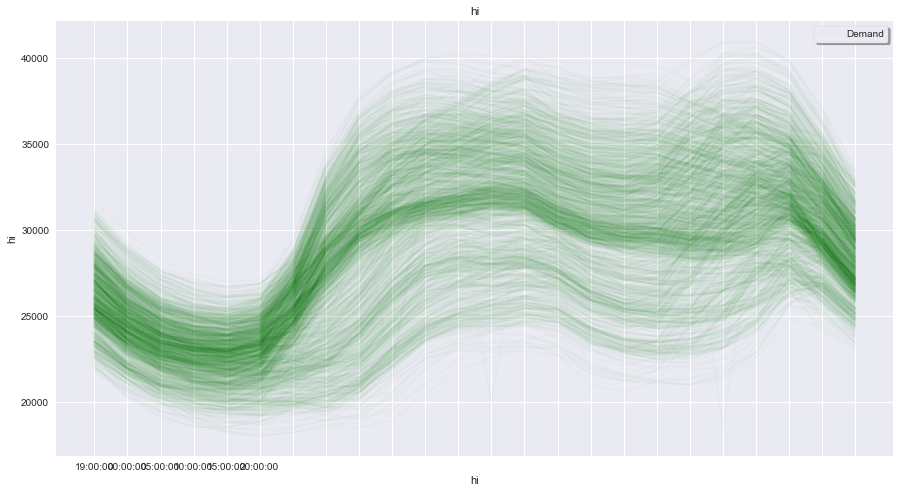

In [234]:
#Create figure
f, ax = plt.subplots(figsize = (15,8))

#Plot data
demand.T.plot(ax = ax, color = 'green', alpha = .02, legend = False,);

#Set plot aesthetics
ax.set_title('hi')
ax.set_xlabel('hi')
ax.set_ylabel('hi')
ax.legend(['Demand'], frameon = True, shadow = True)
ax.set_xticks(np.arange(0,24));


## Apply clustering

In [235]:
#Import libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

#Calculate silhouette score for upto 24 clusters
silhouette_scores = []
n_clusters = np.arange(2,24)

#Create copy of Demand and scale
demand_copy = demand.copy()
scaler = MinMaxScaler()
demand_copy = scaler.fit_transform(demand_copy)

In [236]:
#Fit kmeand and get silhoette scores for each potential value for clusters
for cluster in n_clusters:
    kmeans = KMeans(n_clusters=cluster)
    prediction = kmeans.fit_predict(demand_copy)
    silhouette_scores.append(silhouette_score(demand_copy, kmeans.labels_))

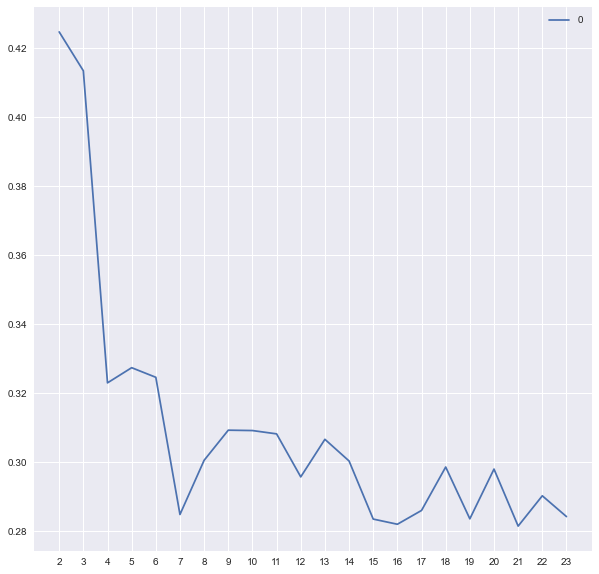

In [237]:
#Store silhouette_scores in a datarame for easy plotting
scores = pd.DataFrame(silhouette_scores,index=n_clusters)

#Create figure
f,ax = plt.subplots(figsize = (10,10))

#Plot data
scores.plot(ax=ax)

#Set plot aesthetics
ax.set_xticks(n_clusters);

In [238]:
#Let's try 3 clusters
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(demand_copy)

#Append clusters to demand as index and set names for index
demand.set_index(clusters, inplace=True, append=True)
demand.index.names = ['date','cluster']

#Check
display(demand.head())

,hour,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,cluster,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,2,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,1,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,27927.0,29072.0,29071.0,29439.0,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,2,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,26454.0,26959.0,26716.0,26802.0,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0
2015-01-04,1,25254.0,23620.0,22606.0,22191.0,21929.0,22195.0,24035.0,26807.0,28316.0,29871.0,30585.0,30772.0,30685.0,30429.0,28741.0,28249.0,28105.0,27908.0,27577.0,27418.0,28604.0,30346.0,28190.0,26270.0
2015-01-05,2,25069.0,23390.0,21988.0,21182.0,20778.0,20309.0,20252.0,19964.0,20796.0,22478.0,23834.0,24429.0,24429.0,24429.0,24429.0,24429.0,24429.0,24429.0,21888.0,22048.0,22858.0,25604.0,25381.0,23822.0


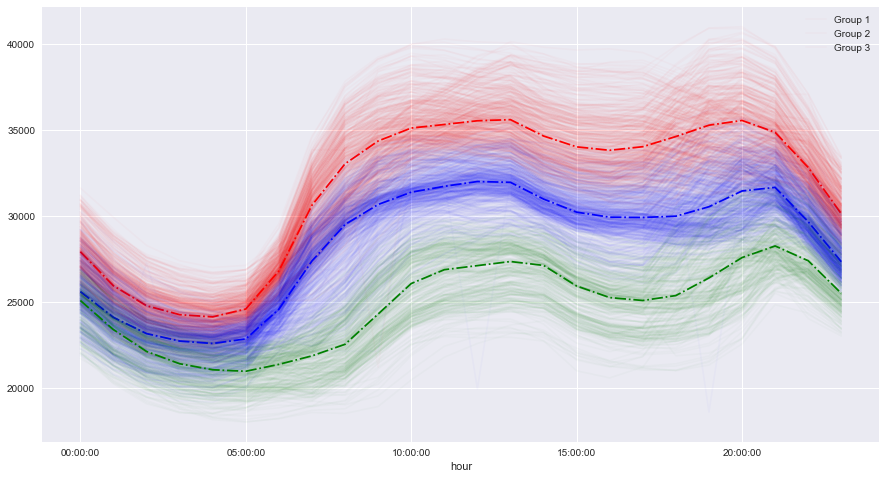

In [247]:
#Create figure
f, ax = plt.subplots(figsize = (15,8))

#Set list of colors for groups
colors = ['red','blue','green']

#Plot data by cluster
for cluster, color in zip(np.unique(clusters), colors):
    demand.xs(cluster, level=1).T.plot(ax=ax, legend = False,color = color, alpha = .02,
                                       label = 'Cluster {}'.format(cluster))
    demand.xs(cluster, level=1).median().plot(ax=ax, color = color, ls = '-.')
    


In [242]:
np.unique(clusters)

array([0, 1, 2])